In [1]:
import ray
import numpy as np
import time
import copy
from IPython.display import clear_output
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import tensorflow as tf

In [3]:
from games.tictactoe import MuZeroConfig
from models_tf import MuZeroNetwork as MuZeroNetworkTF
from models_tf import support_to_scalar as support_to_scalar_tf
from trainer_tf import scalar_to_support as scalar_to_support_tf
from models import MuZeroNetwork
from models import support_to_scalar,scalar_to_support

In [9]:
import torch
import tensorflow as tf

In [4]:
conf = MuZeroConfig()

In [5]:
tf_net = MuZeroNetworkTF(conf,False)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
torch_net = MuZeroNetwork(conf)

In [53]:
test_inp = np.random.random((100,1))*40-20

In [54]:
device = next(torch_net.parameters()).device

In [55]:
inp_tens=torch.tensor(test_inp).float()

In [58]:
support_view = scalar_to_support(inp_tens.reshape(100,1),10).numpy()

In [70]:
inp_sc_ph = tf.placeholder(tf.float32,[None,None,1],'inp_sc')
out_sup = scalar_to_support_tf(inp_sc_ph,10)
support_view_tf = tf_net.sess.run(out_sup,{inp_sc_ph:test_inp.reshape(-1,1,1)})

In [72]:
support_view.shape,support_view_tf.shape

((100, 1, 21), (100, 1, 21))

In [100]:
np.abs((support_view-support_view_tf)).max()

4.7683716e-07

In [86]:
scalar_view = support_to_scalar(torch.tensor(np.log(support_view).reshape(100,21)).float(),10).numpy()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [102]:
inp_supp_ph = tf.placeholder(tf.float32,[None,21],'inp_sup')
out_sc = support_to_scalar_tf(inp_supp_ph,10)
scalar_view_tf = tf_net.sess.run(out_sc,{inp_supp_ph:np.log(support_view_tf).reshape(-1,21)})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [103]:
np.abs(scalar_view-scalar_view_tf).max()

0.00053977966

In [104]:
np.abs(scalar_view_tf.flatten() - test_inp.flatten()).max()

0.0003540702881963398

In [106]:
np.abs(scalar_view.flatten() - test_inp.flatten()).max()

0.00043045228527915924

In [81]:
num_params = 0
for a in torch_net.parameters():
    print(a.shape)
    num_params+=np.array(a.shape).prod()

torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16, 17, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16, 16, 1, 1])
torch.Size([16])
torch.Size([8, 144])
torch.Size([8])
torch.Size([21, 8])
torch.Size([21])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16, 16, 1, 1])
torch.Size([16])
torch.Size([16, 16, 1, 1])
torch.Size([16])
torch.Size([8, 144])
torch.Size([8])
torch.Size([21, 8])
torch.Size([21])
torch.Size([8, 144])
torch.Size([8])
torch.Size([9, 8])
torch.Size([9])


In [82]:
num_params

21715

In [83]:
num_params = 0
for a in tf_net.prediction_model.trainable_weights:
    print(a.shape)
    s = np.array(a.shape).prod()
    num_params+=s

(3, 3, 16, 16)
(16,)
(16,)
(3, 3, 16, 16)
(16,)
(16,)
(1, 1, 16, 16)
(16,)
(1, 1, 16, 16)
(16,)
(144, 8)
(8,)
(144, 8)
(8,)
(8, 9)
(9,)
(8, 21)
(21,)


In [80]:
num_params

Dimension(7806)

In [45]:
params = (tf_net.representation_model.trainable_weights +
                  tf_net.prediction_model.trainable_weights +
                  tf_net.dynamics_model.trainable_weights)

In [54]:
np.array(tf_net.representation_model.trainable_weights[0].shape).prod()

Dimension(864)

In [39]:
tf_net.representation_model.count_params()+tf_net.prediction_model.count_params()+tf_net.dynamics_model.count_params()

21971

In [40]:
tf_net.representation_model.count_params()

5232

In [2]:
def distrib_func(x,noise_std = 0.1):
    r_sq = np.square(x).sum(axis = 1,keepdims = True)
    y = np.exp(-0.1*r_sq)*np.cos(r_sq)
    
    noise = np.random.normal(scale = noise_std,size = y.shape)
    return y+noise
    
    

In [3]:
x = np.random.random(size = (1000,2))*10-5
x[:,1] = 0
y = distrib_func(x)

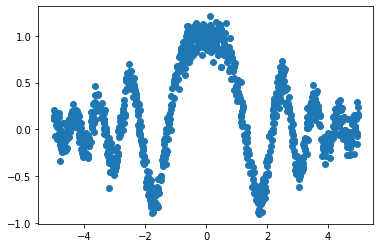

In [4]:
plt.plot(x[:,0],y,'o')

In [5]:
def create_data_batch(batch_size = 16):
    x = np.random.random(size = (batch_size,2))*10-5
    y = distrib_func(x)
    return x,y

In [6]:
test_x,test_y = create_data_batch(batch_size = 64)

In [7]:
class Model:
    def __init__(self, inp_size = (2,)):
        import tensorflow as tf
        sess = tf.get_default_session()
        if sess is not None:
            self.sess = sess
        else:
            self.sess = tf.compat.v1.InteractiveSession()
        self.inp_size = inp_size
        self.feature_size = 128
        
        self.model_1 = self.get_model_1()
        self.model_2 = self.get_model_2()
        self.model_3 = self.get_model_3()
        
        self.in_ph = tf.placeholder(tf.float32,(None,)+self.inp_size, 'in_ph')
        self.conc_ph = tf.placeholder(tf.float32,(None,)+(self.feature_size*2,), 'feats_ph')
        self.out_1_2 = self.run_1_2_anf_concat(self.in_ph)
        self.out_3 = self.run_3(self.conc_ph)
        
        tmp_w = self.get_weights()
        self.sess.run(tf.compat.v1.global_variables_initializer())
        self.set_weights(tmp_w)
    def get_model_1(self):
        import tensorflow as tf
        inp = tf.keras.layers.Input(self.inp_size)
        x = tf.keras.layers.Dense(self.feature_size,activation = 'relu')(inp)
        model = tf.keras.models.Model(inp,x)
        return model
    def get_model_2(self):
        import tensorflow as tf
        inp = tf.keras.layers.Input(self.inp_size)
        x = tf.keras.layers.Dense(self.feature_size,activation = 'relu')(inp)
        model = tf.keras.models.Model(inp,x)
        return model
    def get_model_3(self):
        import tensorflow as tf
        inp = tf.keras.layers.Input((self.feature_size*2,))
        x = tf.keras.layers.Dense(self.feature_size,activation = 'relu')(inp)
        x = tf.keras.layers.Dense(1)(x)
        model = tf.keras.models.Model(inp,x)
        return model
    
    def get_weights(self):
        return [self.model_1.get_weights(),
                self.model_2.get_weights(),
                self.model_3.get_weights()]
    def set_weights(self,weights):
        self.model_1.set_weights(weights[0])
        self.model_2.set_weights(weights[1])
        self.model_3.set_weights(weights[2])
        
    
    def run_1_2_anf_concat(self,tensor_in):
        import tensorflow as tf
        stand = ((tensor_in+5.)/10.)*2.-1.
        a= self.model_1(stand)
        b= self.model_2(stand)
        c = tf.concat(values=[a,b],axis = -1)
        return c
    def run_3(self,tensor_in):
        return self.model_3(tensor_in)
    
    def predict_hidden(self,inp):
        out = self.sess.run(self.out_1_2,{self.in_ph:inp})
        return out
    def predict_out(self,inp):
        out = self.sess.run(self.out_3,{self.conc_ph:inp})
        return out
    def predict_all(self,inp):
        out_1 = self.predict_hidden(inp)
        out_2 = self.predict_out(out_1)
        return out_2

In [8]:
@ray.remote
class SharedStorage:
    """
    Class which run in a dedicated thread to store the network weights and some information.
    """
    def __init__(self, checkpoint):
        self.current_checkpoint = checkpoint

    def get_checkpoint(self):
        return self.current_checkpoint
    def get_info(self, keys):
        if isinstance(keys, str):
            return self.current_checkpoint[keys]
        elif isinstance(keys, list):
            return {key: self.current_checkpoint[key] for key in keys}
        else:
            raise TypeError
    def set_info(self, keys, values=None):
        if isinstance(keys, str) and values is not None:
            self.current_checkpoint[keys] = values
        elif isinstance(keys, dict):
            self.current_checkpoint.update(keys)
        else:
            raise TypeError

In [9]:
@ray.remote
class ReplayBuffer:
    """
    Class which run in a dedicated thread to store the network weights and some information.
    """
    def __init__(self):
        self.buffer = {}
        self.cur_idx_min = 0
        self.cur_idx_max = 0
        self.max_size = 3000
        self.batch_size = 128
        rewards_history = []

    def save_game(self,x,y,preds,shared_storage = None):
        for a,b,c in zip(x,y,preds):
            self.buffer[self.cur_idx_max] = (a,b,c)
            self.cur_idx_max+=1
            
            if self.cur_idx_max>self.max_size:
                del self.buffer[self.cur_idx_min]
                self.cur_idx_min+=1
                
        if shared_storage:
            shared_storage.set_info.remote("num_played_games", self.cur_idx_max)
    def sample_batch(self):
        ids = self.cur_idx_min + np.random.choice(self.cur_idx_max-self.cur_idx_min,self.batch_size)
        x_batch = []
        y_batch = []
        for idx in ids:
            buf = self.buffer[idx]
            x_batch.append(buf[0])
            y_batch.append(buf[1])
        return np.vstack(x_batch),np.vstack(y_batch)
    
    def get_latest_loss(self):
        ids = np.arange(self.cur_idx_max -self.batch_size,self.cur_idx_max,dtype = int)
        y_trg = []
        y_pred = []
        for idx in ids:
            if idx in self.buffer:
                buf = self.buffer[idx]
                y_trg.append(buf[1])
                y_pred.append(buf[2])
        if len(y_trg)>1:
            y_trg,y_pred = np.vstack(y_trg),np.vstack(y_pred)
        else:
            y_trg,y_pred = 0,0
        return np.mean(np.square(y_trg-y_pred))

In [10]:
@ray.remote
class Player():
    def __init__(self,checkpoint):
        self.model = Model()
        self.model.set_weights(checkpoint['weights'])
        self.played_iters = 0
        self.to_play = 100000000
        
        
    def play(self,shared_storage,replay_buffer):
        while self.played_iters<self.to_play:
            self.model.set_weights(ray.get(shared_storage.get_info.remote("weights")))
            x,y = create_data_batch(64)
            preds = self.model.predict_all(x)
            replay_buffer.save_game.remote(x,y,preds,shared_storage)
            self.played_iters+=1

In [11]:
@ray.remote
class Trainer():
    def __init__(self,checkpoint=None):
        import tensorflow as tf
        self.steps_done = 0
        self.max_train_steps = 10000000
        self.checkpoint_interval = 100
        self.model = Model()
        if checkpoint:
            init_w = checkpoint['weights']
            self.model.set_weights(init_w)
        self.sess = self.model.sess
        self.in_ph = tf.placeholder(tf.float32,(None,)+self.model.inp_size, 'in_ph')
        self.target_ph = tf.placeholder(tf.float32,(None,1), 'trg_ph')
        
        self.optimizer = tf.compat.v1.train.AdamOptimizer(0.01)
        [self.loss,self.make_train_step] = self.train_symbolic(self.in_ph, self.target_ph)
        tmp_w = self.model.get_weights()
        self.sess.run(tf.compat.v1.global_variables_initializer())
        self.model.set_weights(tmp_w)
        
    
    def train_symbolic(self,inp, trg):
        import tensorflow as tf
        h = self.model.run_1_2_anf_concat(inp)
        out = self.model.run_3(h)
        loss = tf.reduce_mean(tf.square(out-trg))
        step = self.optimizer.minimize(loss)
        return loss, step
    
    def make_step(self,train_batch):
        x_batch,y_batch = train_batch            
        loss,_ = self.sess.run([self.loss,self.make_train_step],{self.in_ph: x_batch,
                                                                 self.target_ph: y_batch})
        return loss
    
    def train(self,replay_buffer, shared_storage):
        while ray.get(shared_storage.get_info.remote("num_played_games")) < 1:
            time.sleep(1)
        while self.steps_done<self.max_train_steps:
            train_batch = ray.get(replay_buffer.sample_batch.remote())
            loss = self.make_step(train_batch)
            self.steps_done+=1
            info_to_storage = ray.put({
                        "weights": self.model.get_weights(),
                        "loss": loss})
            if self.steps_done % self.checkpoint_interval == 0:
                shared_storage.set_info.remote(info_to_storage)
                
    def train_standalone(self,replay_buffer, shared_storage):
        while ray.get(shared_storage.get_info.remote("num_played_games")) < 1:
            time.sleep(1)
        while self.steps_done<self.max_train_steps:
            train_batch = create_data_batch(64)
            loss = self.make_step(train_batch)
            self.steps_done+=1
            info_to_storage = ray.put({
                        "weights": self.model.get_weights(),
                        "loss": loss})
            if self.steps_done % self.checkpoint_interval == 0:
                shared_storage.set_info.remote(info_to_storage)
                
#             time.sleep(0.5)
            

In [12]:
@ray.remote(num_cpus=0, num_gpus=0)
class CPUActor:
    # Trick to force DataParallel to stay on CPU to get weights on CPU even if there is a GPU
    def __init__(self):
        pass
    def get_initial_weights(self):
        model = Model()
        weigths = model.get_weights()
        # summary = str(model).replace("\n", " \n\n")
        return weigths

In [13]:
# trainer = Trainer()

In [14]:
# played_steps = []
# train_losses = []
# for ep in range(100):
#     for s in range(1000):
#         train_batch = create_data_batch(512)
#         train_loss = trainer.make_step(train_batch)
#         train_losses.append(train_loss)

#     clear_output(True)
#     plt.plot(train_losses)  
#     plt.show()
#     plt.ylim(0,0.4)
    

In [15]:
ray.init()

2021-02-17 11:29:36,174	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.200',
 'raylet_ip_address': '192.168.1.200',
 'redis_address': '192.168.1.200:6379',
 'object_store_address': 'tcp://127.0.0.1:65408',
 'raylet_socket_name': 'tcp://127.0.0.1:65464',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\PAVELK~1.ALT\\AppData\\Local\\Temp\\ray\\session_2021-02-17_11-29-34_885682_10280',
 'metrics_export_port': 65488,
 'node_id': '5057f7d8c801c5baba6a78ece83e17d4b21acae8'}

In [16]:
checkpoint = {"weights": None,"loss":0,'num_played_games':0}

In [17]:
cpu_actor = CPUActor.remote()
cpu_weights = cpu_actor.get_initial_weights.remote()

In [18]:
checkpoint["weights"] = ray.get(cpu_weights)

(pid=7156) 2021-02-17 11:29:46.327430: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
(pid=7156) 2021-02-17 11:29:46.345093: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library nvcuda.dll
(pid=7156) 2021-02-17 11:29:46.499464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
(pid=7156) name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
(pid=7156) pciBusID: 0000:42:00.0
(pid=7156) 2021-02-17 11:29:46.508221: I tensorflow/stream_executor/platform/default/dlopen_checker_stub.cc:25] GPU libraries are statically linked, skip dlopen check.
(pid=7156) 2021-02-17 11:29:46.511316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1763] Adding visible gpu devices: 0
(pid=7156) 2021-02-17 11:29:47.349318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1181] Device interconnect StreamExecuto

In [19]:
training_worker = Trainer.options(num_cpus=0, num_gpus=0).remote(checkpoint)

shared_storage_worker = SharedStorage.remote(checkpoint)

replay_buffer_worker = ReplayBuffer.remote()

num_workers = 4

self_play_workers = [Player.options(num_cpus=0,num_gpus=0).remote(checkpoint)
            for seed in range(num_workers)
        ]

In [20]:
 [self_play_worker.play.remote(shared_storage_worker, replay_buffer_worker)
            for self_play_worker in self_play_workers]

training_worker.train.remote(replay_buffer_worker, shared_storage_worker)
# training_worker.train_standalone.remote(replay_buffer_worker, shared_storage_worker)

ObjectRef(fafba2bafaed5dc37bbd90280100000001000000)

(pid=7268) 2021-02-17 11:30:02.135723: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not c
(pid=21832) 2021-02-17 11:30:02.136485: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary 
(pid=21832) w
(pid=10068) 2021-02-17 11:30:02.135258: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled t
(pid=19984) 2021-02-17 11:30:02.132304: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
(pid=7268) ompiled to use: AVX2
(pid=7268) 2021-02-17 11:30:02.156732: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dy
(pid=21832) as not compiled to use: AVX2
(pid=21832) 2021-02-17 11:30:02.157257: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully ope

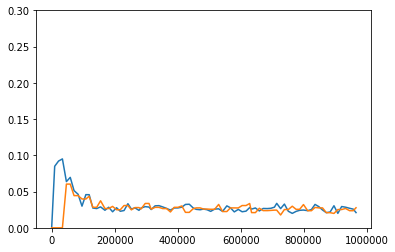

KeyboardInterrupt: 

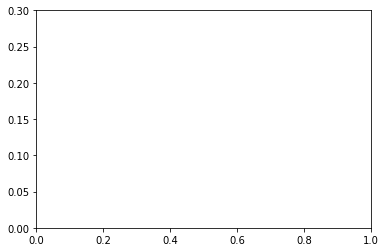

In [21]:
played_steps = []
wrk_losses = []
train_losses = []
for i in range(1000):
    steps_played = ray.get(shared_storage_worker.get_info.remote("num_played_games"))
    wrk_loss = ray.get(replay_buffer_worker.get_latest_loss.remote())
    train_loss = ray.get(shared_storage_worker.get_info.remote("loss"))
    played_steps.append(steps_played)
    wrk_losses.append(wrk_loss)
    train_losses.append(train_loss)
    
    clear_output(True)
    plt.plot(played_steps,wrk_losses)
    plt.plot(played_steps,train_losses)  
    plt.show()
    plt.ylim(0,0.3)
    time.sleep(0.5)
    

In [22]:
weights = ray.get(shared_storage_worker.get_info.remote("weights"))

In [23]:
model = Model()
model.set_weights(weights)
# model = trainer.model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
x = np.random.random(size = (1000,2))*10-5
x[:,1] = 0
y = distrib_func(x)

In [25]:
y_pred = model.predict_all(x)

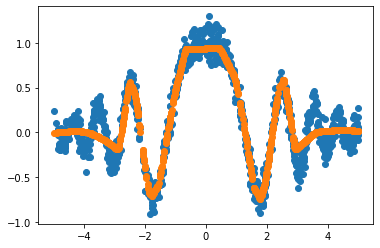

In [26]:
plt.plot(x[:,0],y,'o')
plt.plot(x[:,0],y_pred,'o')

In [26]:
np.square(y.mean()-y).mean()

0.31723504376670986

In [27]:
np.square(y_pred-y).mean()

0.3003781416572673